In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import cv2
import rad_target_detection as rtd
import tkinter as tk
from tkinter.filedialog import askopenfilenames
import os

In [4]:
# Load image with file dialog
start = os.getcwd()
root = tk.Tk()
filename = tk.filedialog.askopenfilenames(title='Select Input File')
root.destroy()
filename = os.path.relpath(filename[0],start)
filename
image = cv2.imread(filename)

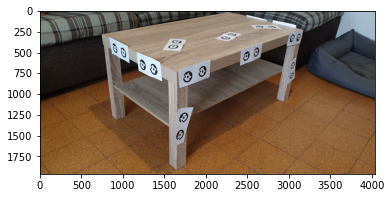

In [5]:
# load image
# image = cv2.imread(r'.\table_targets\20210325_121543.jpg')
# image = cv2.imread(r'.\Shaul_Car2\)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # rgb image
rgb_img = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # gray image

plt.imshow(rgb_img)
plt.show()

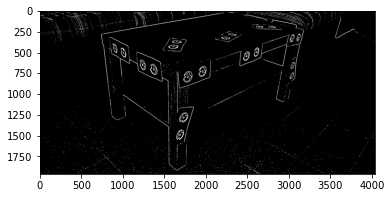

In [6]:
# firstly we will threshold the image to make it binary
binary_img = rtd.binarize_image(gray,d=10, sig1=100, sig2=100, b_size=13, c=5)

plt.imshow(binary_img, cmap='gray')
plt.show()

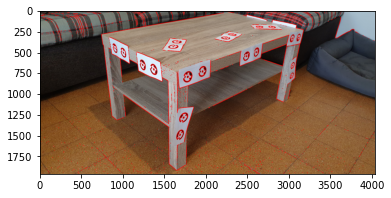

In [7]:
# getting contours of the binary image
contour_thresh=5

contours = rtd.contour_image(binary_img, contour_thresh)
c_img = rgb_img.copy()
cv2.drawContours(c_img, contours, -1, (255, 0, 0), 2)
plt.imshow(c_img)
plt.show()

In [8]:
# next step is to fit ellipses to the contours and filter out ones that cannot be candidates for target
ellipses, hulls = rtd.find_ellipses(contours)

[INFO] fitting ellipses to contours
[INFO] found 1836 valid ellipses


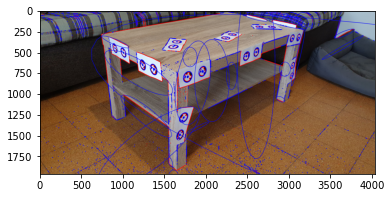

In [9]:
for i, ellip in enumerate(ellipses):
    rtd.draw_ellipse(c_img, ellip[0], ellip[1], ellip[2], 0, 360, (0, 0, 255))
plt.imshow(c_img)
plt.show()

In [10]:
# find concentric ellipses, check to see if ratio applies between each pair of concentric ellipses
rad_targets = rtd.find_rad_targets(ellipses, lower_thresh=3.5, upper_thresh=7.5)

[INFO] filtering the suspected targets from ellipses
100%|██████████| 1684530/1684530 [01:28<00:00, 18953.27it/s][INFO] found 49 suspected as RAD targets



[INFO] for target center (1651.0, 1635.0) - NOT A TARGET
[INFO] for target center (1686.0, 1489.0) - NOT A TARGET
[INFO] for target center (1546.0, 1353.0) - NOT A TARGET
[INFO] for target center (1712.0, 1318.0) the coding is 111111111111
[INFO] for target center (1729.0, 1281.0) - NOT A TARGET
[INFO] for target center (1730.0, 1277.0) - NOT A TARGET
[INFO] for target center (1730.0, 1277.0) - NOT A TARGET
[INFO] for target center (1778.0, 792.0) - NOT A TARGET
[INFO] for target center (1778.0, 792.0) the coding is 101011010000
[INFO] for target center (1778.0, 792.0) the coding is 101011010000
[INFO] for target center (3030.0, 779.0) the coding is 101000000000
[INFO] for target center (1467.0, 772.0) the coding is 111100111101
[INFO] for target center (1956.0, 726.0) - NOT A TARGET
[INFO] for target center (1368.0, 703.0) - NOT A TARGET
[INFO] for target center (3041.0, 656.0) the coding is 100000000000
[INFO] for target center (1236.0, 649.0) the coding is 111111111111
[INFO] for ta

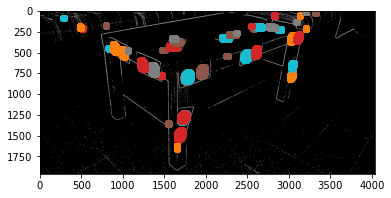

In [11]:
# coding each target by it's shape
targets_df = rtd.targets_encoding(binary_img, rad_targets)

In [12]:
# color map for the data
cmap = rtd.get_cmap_string(palette='viridis', domain=targets_df['code'])
targets_df['color'] = targets_df['code'].apply(cmap)

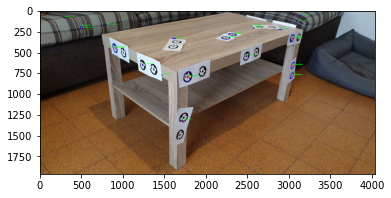

In [13]:
# drawing found targets on img
rtd.draw_targets(rgb_img, targets_df)
plt.imshow(rgb_img)
plt.show()